In [26]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

# import smote
from imblearn.over_sampling import SMOTE

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from lightgbm import LGBMRegressor

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, PowerTransformer

# Zero regression
from sklearn.base import BaseEstimator, RegressorMixin, clone, is_classifier, is_regressor
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y

# Metrics for regression
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, max_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score

# Metrics for classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report,matthews_corrcoef

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, PowerTransformer, MaxAbsScaler

#  balenced regression
from imblearn.ensemble import BalancedBaggingClassifier

In [5]:
class ZeroInflatedRegressor(BaseEstimator, RegressorMixin):
    """A meta regressor for zero-inflated datasets, i.e. the targets contain a lot of zeroes.

    `ZeroInflatedRegressor` consists of a classifier and a regressor.

        - The classifier's task is to find if the target is zero or not.
        - The regressor's task is to output a (usually positive) prediction whenever the classifier indicates that the
        there should be a non-zero prediction.

    The regressor is only trained on examples where the target is non-zero, which makes it easier for it to focus.

    At prediction time, the classifier is first asked if the output should be zero. If yes, output zero.
    Otherwise, ask the regressor for its prediction and output it.

    Parameters
    ----------
    classifier : scikit-learn compatible classifier
        A classifier that answers the question "Should the output be zero?".
    regressor : scikit-learn compatible regressor
        A regressor for predicting the target. Its prediction is only used if `classifier` says that the output is
        non-zero.

    Attributes
    ----------
    classifier_ : scikit-learn compatible classifier
        The fitted classifier.
    regressor_ : scikit-learn compatible regressor
        The fitted regressor."""

    def __init__(self, classifier, regressor) -> None:
        self.classifier = classifier
        self.regressor = regressor

    def fit(self, X, y, sample_weight=None):
        """Fit the underlying classifier and regressor using `X` and `y` as training data. The regressor is only trained
        on examples where the target is non-zero.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training data.
        y : array-like of shape (n_samples,)
            The target values.
        sample_weight : array-like of shape (n_samples,), default=None
            Individual weights for each sample.

        Returns
        -------
        self : ZeroInflatedRegressor
            The fitted estimator.

        Raises
        ------
        ValueError
            If `classifier` is not a classifier or `regressor` is not a regressor.
        """
        X, y = check_X_y(X, y)
        self._check_n_features(X, reset=True)
        if not is_classifier(self.classifier):
            raise ValueError(
                f"`classifier` has to be a classifier. Received instance of {type(self.classifier)} instead."
            )
        if not is_regressor(self.regressor):
            raise ValueError(f"`regressor` has to be a regressor. Received instance of {type(self.regressor)} instead.")

        try:
            check_is_fitted(self.classifier)
            self.classifier_ = self.classifier
        except NotFittedError:
            self.classifier_ = clone(self.classifier)

            if "sample_weight" in signature(self.classifier_.fit).parameters:
                self.classifier_.fit(X, y != 0, sample_weight=sample_weight)
            else:
                logging.warning("Classifier ignores sample_weight.")
                self.classifier_.fit(X, y != 0)

        non_zero_indices = np.where(self.classifier_.predict(X) == 1)[0]

        if non_zero_indices.size > 0:
            try:
                check_is_fitted(self.regressor)
                self.regressor_ = self.regressor
            except NotFittedError:
                self.regressor_ = clone(self.regressor)

                if "sample_weight" in signature(self.regressor_.fit).parameters:
                    self.regressor_.fit(
                        X[non_zero_indices],
                        y[non_zero_indices],
                        sample_weight=sample_weight[non_zero_indices] if sample_weight is not None else None,
                    )
                else:
                    logging.warning("Regressor ignores sample_weight.")
                    self.regressor_.fit(
                        X[non_zero_indices],
                        y[non_zero_indices],
                    )
        else:
            raise ValueError(
                """The predicted training labels are all zero, making the regressor obsolete. Change the classifier
                or use a plain regressor instead."""
            )

        return self

    def predict(self, X):
        """Predict target values for `X` using fitted estimator by first asking the classifier if the output should be
        zero. If yes, output zero. Otherwise, ask the regressor for its prediction and output it.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data to predict.

        Returns
        -------
        array-like of shape (n_samples,)
            The predicted values.
        """
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)

        output = np.zeros(len(X))
        non_zero_indices = np.where(self.classifier_.predict(X))[0]

        if non_zero_indices.size > 0:
            output[non_zero_indices] = self.regressor_.predict(X[non_zero_indices])

        return output

In [21]:
def runner(scaler, model, X_train, y_train, X_test):
    scaler.fit(X_train)
    Xt_train = scaler.transform(X_train)
    Xt_test = scaler.transform(X_test)

    model.fit(Xt_train, y_train)
    preds = model.predict(Xt_test)
    return preds

def sc_tester(model, X_train, y_train, X_test, y_test):      
    scalers = [StandardScaler(), MinMaxScaler(), PowerTransformer(), RobustScaler(), MaxAbsScaler()]
    results = []

    for scaler in scalers:
        preds = runner(scaler, model, X_train, y_train, X_test)

        f1 = f1_score(y_test, preds, average="weighted")
        accuracy = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds, average="weighted")
        recall = recall_score(y_test, preds, average="weighted")
        mcc = matthews_corrcoef(y_test, preds)

        result_dict = {
            'Scaler': str(scaler),
            'Model': str(model),
            'F1 Score': f1,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'MCC': mcc
        }

        results.append(result_dict)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['MCC'], ascending=False)
    return results_df

## Data preprocessing

In [6]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))

In [7]:
X_train = pd.DataFrame(X_train, columns=col_names)

In [8]:
y_train = pd.DataFrame(y_train, columns=['target'])

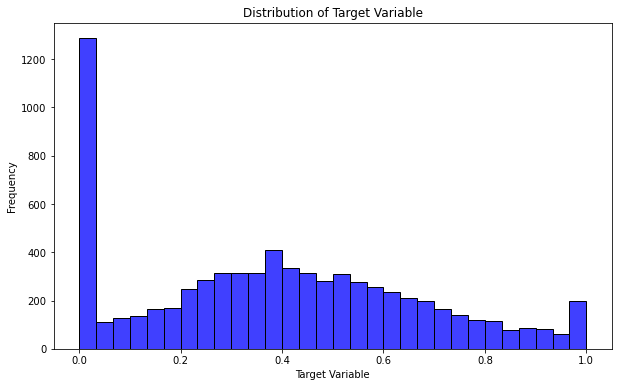

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train.values.flatten(), bins=30, kde=False, color='blue')
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.show()

In [11]:
y_train.value_counts()

target  
0.000000    1207
1.000000     168
0.349999      56
0.374999      51
0.324999      47
            ... 
0.282986       1
0.282692       1
0.282500       1
0.282399       1
0.363435       1
Length: 2476, dtype: int64

As seen in the histogram and through value counts, y = 0.0 occurs much more frequently than other values - the target variable is imbalanced, which may pose a problem later on if not dealt with wisely.

In [12]:
X_train.columns[X_train.isnull().any()]

Index([], dtype='object')

No columns with missing values.

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337 entries, 0 to 7336
Columns: 2132 entries, D00 to FP2088
dtypes: float64(2132)
memory usage: 119.3 MB


Columns consist of type 'float64' only. Let's further inspect this.

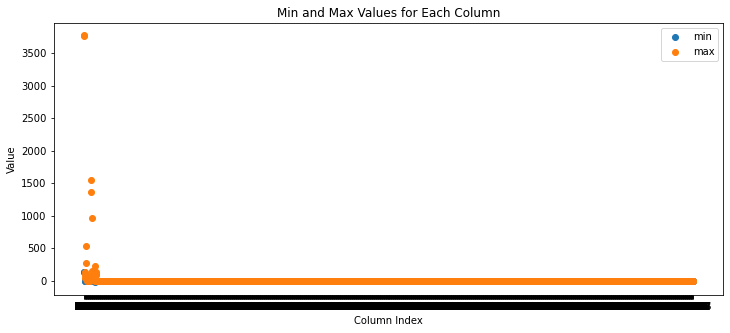

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(X_train.min(axis=0), 'o', label="min") 
plt.plot(X_train.max(axis=0), 'o', label="max")
plt.title('Min and Max Values for Each Column')
plt.legend(loc="best")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.show()

While some columns are indeed floats, the majority seem to be binary and not floats as originally encoded.

In [15]:
binary_filter = X_train.apply(lambda col: set(col) == {0, 1}) #columns containing only 0s and 1s
binary_columns = X_train.columns[binary_filter].tolist()
X_train[binary_columns] = X_train[binary_columns].astype('category')

binary_df = X_train[binary_columns]
binary_df.shape

(7337, 2090)

Training set consisting of binary columns only, all of type 'category'. 2090 samples.

In [16]:
float_filter = ~X_train.columns.isin(binary_columns) #remaining columns (not in binary_columns)
float_columns = X_train.columns[float_filter].tolist()

float_df = X_train[float_columns]
float_df.shape

(7337, 42)

Training set consisting of all remaining columns of type 'float64'. 42 samples.

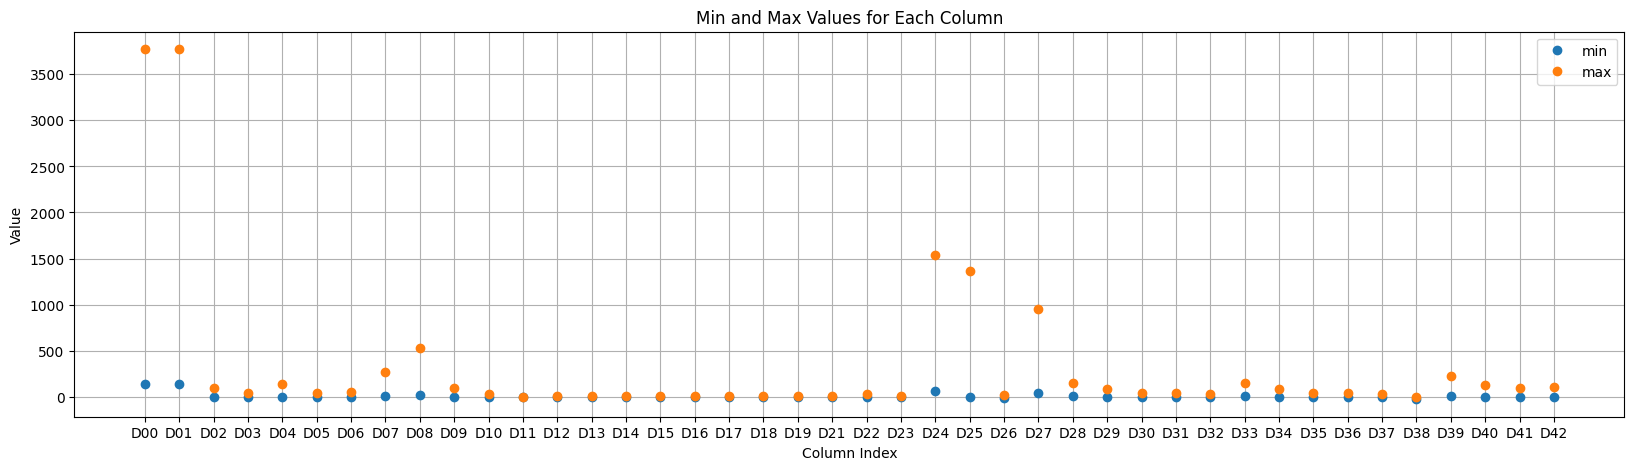

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(float_df.min(axis=0), 'o', label="min") 
plt.plot(float_df.max(axis=0), 'o', label="max")
plt.legend(loc="best")
plt.grid()
plt.title("Min and Max Values for Each Column")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.show()

As there seems to be an overlap of min and max values for some columns, let's double check everything is correct with these columns.

In [18]:
results = []
for col in float_df:
    min_val = float_df[col].min()
    max_val = float_df[col].max()
    results.append((col, min_val, max_val))

check = pd.DataFrame(results, columns=['column', 'min', 'max'])
check

,column,min,max
0,D00,135.068414,3768.848446
1,D01,135.166000,3771.262000
2,D02,1.000000,92.000000
3,D03,0.000000,47.000000
4,D04,0.000000,137.000000
5,D05,0.000000,42.000000
6,D06,0.000000,58.000000
7,D07,10.000000,266.000000
8,D08,19.000000,527.000000
9,D09,1.000000,93.000000


In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337 entries, 0 to 7336
Columns: 2132 entries, D00 to FP2088
dtypes: category(2090), float64(42)
memory usage: 17.2 MB


2090 columns of type 'category' and 42 of type 'float64', as intended.

# Methodology 

Due to the way the daset is structured, we will be using a two-step approach to the problem. First, we will use the 2090 columns of type 'category' to train a model, and then use the 42 columns of type 'float64' to train a second model. Finally, we will combine the predictions of both models to obtain the final result.

- The categorical columns will be named "Binary"

- The float columns will be named "Float"


Given the nature of this dataset with a large number of zeros on the target variable, we will devide the dataset into two parts, classification and regression. The classification part will be used to predict the probability of the target variable being 0 or diferent than 0. The regression part will be used to predict the value of the target variable when it is different than 0. So we will a:
- Classification model
- Regression model.

# Classification models

In [14]:
def classification_evaluation(y_test_clf, predictions):

    accuracy = accuracy_score(y_test_clf, predictions)
    precision = precision_score(y_test_clf, predictions)
    recall = recall_score(y_test_clf, predictions)
    f1 = f1_score(y_test_clf, predictions)
    mcc = matthews_corrcoef(y_test_clf, predictions)

    results = {'Test Accuracy': [accuracy], 'Test Precision': [precision], 'Test Recall': [recall], 'Test F1': [f1], 'Test MCC': [mcc]} 
    results_df = pd.DataFrame(results)
    
    return results_df

def classification_model_evaluation(X_train, X_test, y_train, y_test, classifiers):
    
    results_list = []
    for name, (classifier, param_grid) in classifiers.items():
        clf = classifier()
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_micro', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        predictions = best_model.predict(X_test)
        results = classification_evaluation(y_test, predictions)
        results_dict = {'Classifier': name, 'Best Params': best_params}
        results_dict.update(results.iloc[0].to_dict())  # Add evaluation metrics to the results_dict
        results_list.append(results_dict)
    
    results_df = pd.DataFrame(results_list)
    return results_df


classifier_params = {
    'Logistic Regression': (LogisticRegression, {'C': [0.001, 0.01, 0.1, 1.0, 10.0], 'max_iter': [1000]}),
    'SVM': (SVC, {'C': [0.001, 0.01, 0.1, 1.0], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}),
    'Decision Tree': (DecisionTreeClassifier, {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}),
    'Random Forest': (RandomForestClassifier, {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    'LightGBM': (LGBMClassifier, {'n_estimators': [50, 100, 200, 500, 600], 'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80], 'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0]}),
    'Balanced Bagging': (BalancedBaggingClassifier(
        base_estimator=LGBMClassifier(learning_rate=0.2, n_estimators=600),
        sampling_strategy='not majority',
        replacement=True,
        random_state=23
    ))
}


### Create the dataset for the classification model

In [15]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))

X_train = pd.DataFrame(X_train, columns=col_names)
y_train = pd.DataFrame(y_train, columns=['Target'])

In [16]:
def binary(row):
    if row['Target'] == 0:
        return 1
    else:
        return 0

In [17]:
y_train_class = y_train.copy()
y_train_class['Target'] = y_train_class.apply(binary, axis=1) # convert to binary
y_train_class = y_train_class.astype('category')

### Binary

In [18]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

binary_x = X_train[binary_columns_train].copy()
binary_y = y_train_class.copy()

# Split data into train and test
X_train_bin_cl, X_test_bin_cl, y_train_bin_cl, y_test_bin_cl = train_test_split(binary_x, binary_y, test_size=0.2, random_state=23)

### Floats

In [19]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

float_x = X_train.drop(binary_columns_train, axis=1).copy()
float_y = y_train_class.copy()

# Split data into train and test
X_train_float_cl, X_test_float_cl, y_train_float_cl, y_test_float_cl = train_test_split(float_x, float_y, test_size=0.2, random_state=23)

## Binary models

In [ ]:
results_bin_cl=classification_model_evaluation(X_train_bin_cl, X_test_bin_cl, y_train_bin_cl, y_test_bin_cl, classifier_params)
results_bin_cl

bla bla bla the best one is bla bla bla

# Float models

As previously inspected, these columns have quite different distributions and ranges, which means that scaling them is an important step. Let's try different scalers and see how they behave with different classifiers.

In [27]:
rfc_scaler = sc_tester(RandomForestClassifier(), X_train_float_cl, y_train_float_cl, X_test_float_cl, y_test_float_cl)
rfc_scaler

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
1,MinMaxScaler(),RandomForestClassifier(),0.855375,0.872616,0.855845,0.872616,0.416697
2,PowerTransformer(),RandomForestClassifier(),0.853931,0.871935,0.854775,0.871935,0.410791
0,StandardScaler(),RandomForestClassifier(),0.852927,0.871253,0.853762,0.871253,0.406454
4,MaxAbsScaler(),RandomForestClassifier(),0.851371,0.869891,0.851793,0.869891,0.399388
3,RobustScaler(),RandomForestClassifier(),0.850189,0.867847,0.849178,0.867847,0.393250


In [28]:
lg_scaler = sc_tester(LogisticRegression(max_iter=10000), X_train_float_cl, y_train_float_cl, X_test_float_cl, y_test_float_cl)
lg_scaler

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
2,PowerTransformer(),LogisticRegression(max_iter=10000),0.797791,0.850136,0.814188,0.850136,0.170605
3,RobustScaler(),LogisticRegression(max_iter=10000),0.790723,0.848774,0.810413,0.848774,0.135308
0,StandardScaler(),LogisticRegression(max_iter=10000),0.789622,0.848774,0.811426,0.848774,0.130691
4,MaxAbsScaler(),LogisticRegression(max_iter=10000),0.783820,0.848774,0.828706,0.848774,0.107795
1,MinMaxScaler(),LogisticRegression(max_iter=10000),0.782234,0.848093,0.820916,0.848093,0.091297


In [29]:
dt_scaler = sc_tester(DecisionTreeClassifier(), X_train_float_cl, y_train_float_cl, X_test_float_cl, y_test_float_cl)
dt_scaler

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
1,MinMaxScaler(),DecisionTreeClassifier(),0.832728,0.832425,0.833035,0.832425,0.356726
3,RobustScaler(),DecisionTreeClassifier(),0.830615,0.829700,0.831562,0.829700,0.351011
0,StandardScaler(),DecisionTreeClassifier(),0.825124,0.822207,0.828354,0.822207,0.338300
4,MaxAbsScaler(),DecisionTreeClassifier(),0.821693,0.818120,0.825714,0.818120,0.327970
2,PowerTransformer(),DecisionTreeClassifier(),0.817966,0.819482,0.816520,0.819482,0.293017


In [30]:
svc_scaler = sc_tester(SVC(), X_train_float_cl, y_train_float_cl, X_test_float_cl, y_test_float_cl)
svc_scaler

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
2,PowerTransformer(),SVC(),0.813329,0.858311,0.840041,0.858311,0.258951
0,StandardScaler(),SVC(),0.801609,0.856267,0.855380,0.856267,0.227297
4,MaxAbsScaler(),SVC(),0.793508,0.853542,0.862777,0.853542,0.192380
3,RobustScaler(),SVC(),0.785767,0.850136,0.851182,0.850136,0.135244
1,MinMaxScaler(),SVC(),0.776456,0.846730,0.716952,0.846730,0.000000


In [31]:
lgbm_scaler = sc_tester(LGBMClassifier(), X_train_float_cl, y_train_float_cl, X_test_float_cl, y_test_float_cl)
lgbm_scaler

[LightGBM] [Info] Number of positive: 982, number of negative: 4887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 5869, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167320 -> initscore=-1.604743
[LightGBM] [Info] Start training from score -1.604743
[LightGBM] [Info] Number of positive: 982, number of negative: 4887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6015
[LightGBM] [Info] Number of data points in the train set: 5869, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167320 -> initscore=-1.604743
[LightGBM] [Info] Start training from score -1.604743
[LightGBM] [Info] Nu

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
2,PowerTransformer(),LGBMClassifier(),0.866607,0.882153,0.869262,0.882153,0.466616
3,RobustScaler(),LGBMClassifier(),0.865793,0.882153,0.869413,0.882153,0.464169
1,MinMaxScaler(),LGBMClassifier(),0.864098,0.882153,0.869987,0.882153,0.459545
4,MaxAbsScaler(),LGBMClassifier(),0.863109,0.879428,0.865475,0.879428,0.451472
0,StandardScaler(),LGBMClassifier(),0.861418,0.877384,0.862604,0.877384,0.443175


Although not by much, the PowerTransformer scaler seems to be one of the most appropriate, so it is the one to be used.

In [32]:
scaler = PowerTransformer()
X_train_float = scaler.fit_transform(X_train_float_cl)
X_test_float = scaler.transform(X_test_float_cl)

In [ ]:
results_float = classification_model_evaluation(X_train_float_cl, X_test_float_cl, y_train_float_cl, y_test_float_cl, classifier_params)
results_float

In [ ]:
results_float.iloc[4]["Best Params"] #apparent best model

Now let's test the apparent best model with SMOTE to try to deal with the imbalance of our dataset, and without it, and see how they compare.

In [ ]:
scaler_float = PowerTransformer()
X_train_float_scaled = scaler_float.fit_transform(X_train_float_clf)
X_test_float_scaled = scaler_float.transform(X_test_float_clf)

sm = SMOTE(random_state=23)
X_train_float_resampled, y_train_float_resampled = sm.fit_resample(X_train_float_scaled, y_train_float_clf)
results_float = classification_model_evaluation(X_train_float_resampled, X_test_float_scaled, y_train_float_resampled, y_test_float_clf, classifier_params)
results_float

#without SMOTE
model = LGBMClassifier(learning_rate=0.1, n_estimators=600, num_leaves=40) #best classifier
model.fit(X_train_float_scaled, y_train_float_clf)

preds = model.predict(X_test_float_scaled)
classification_evaluation(y_test_float_clf, preds)

In [ ]:
#with SMOTE
model = LGBMClassifier(learning_rate=0.1, n_estimators=600, num_leaves=40)
model.fit(X_train_float_resampled, y_train_float_resampled)

preds = model.predict(X_test_float_scaled)
classification_evaluation(y_test_float_clf, preds)

(results are better with...) Let's see if performing PCA helps.

In [ ]:
pca = PCA(n_components=0.9) #to retain 90% of the original variance
X_train_float_pca = pca.fit_transform(X_train_float_resampled)
X_test_float_pca = pca.transform(X_test_float_scaled)

model = LGBMClassifier(learning_rate=0.1, n_estimators=600, num_leaves=40) #apparent best classifier
model.fit(X_train_float_pca, y_train_float_resampled)

preds_pca = model.predict(X_test_float_pca)
classification_evaluation(y_test_float_clf, preds_pca)

(results with PCA bla bla)

# Regression model

In [ ]:
def regression_evaluation_df(truth, preds):
    rve = explained_variance_score(truth, preds)
    rmse = mean_squared_error(truth, preds, squared=False)
    max_err = max_error(truth, preds)
    mae = mean_absolute_error(truth, preds)

    results = {'Test RVE': [rve], 'Test RMSE': [rmse], 
               'Test Maximum Error': [max_err], 'Test MAE': [mae]} 
    results_df = pd.DataFrame(results)

    return results_df

def regression_model_evaluation(X_train, X_test, y_train, y_test, models, classifier):

    final_results = pd.DataFrame()

    for name, regressor in models.items():

        zir = ZeroInflatedRegressor(
            classifier=classifier,
            regressor=regressor
        )

        zir.fit(X_train, y_train)
        y_pred = zir.predict(X_test)

        result= regression_evaluation_df(y_test, y_pred)
        result.rename(index={0: name}, inplace=True)
        final_results = pd.concat([final_results, result])


    return final_results

models={'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(random_state=23),
        'XGBoost Regression': XGBRegressor(random_state=23),
        'SVR': SVR(),
        'Decision Tree': DecisionTreeRegressor(  random_state=23),
 }

for i in (100,200,300,500,800,1000):
    for j in [None,2,4,8,10,20,30]:
        for k in [None,2,4,5,8,10]:
            models[f'Random Forest  n_estimators={i}, max_depth={j}'] = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=23)

for i in (100,200,300,500,800,1000):
    for j in [None,2,4,8,10,20,30]:
        for k in [None,2,4,5,8,10]:
            for l in [None, 0.001, 0.01, 0.1, 1.0]:
                models[f'LightGBM  n_estimators={i}, max_depth={j}'] = LGBMRegressor(n_estimators=i, max_depth=j, random_state=23,)
                models[f'XBoost  n_estimators={i}, max_depth={j}'] = XGBRegressor(n_estimators=i, max_depth=j, random_state=23)

## Create the dataset for the regression models

In [ ]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))

X_train= pd.DataFrame(X_train, columns=col_names)
y_train = pd.DataFrame(y_train, columns=['Target'])

### Binary

In [ ]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

binary_x = X_train[binary_columns_train].copy()
binary_y = y_train.copy()

# Split data into train and test
X_train_bin_reg, X_test_bin_reg, y_train_bin_reg, y_test_bin_reg = train_test_split(binary_x, binary_y, test_size=0.2, random_state=23)

### Floats

In [ ]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

float_x = X_train.drop(binary_columns_train, axis=1).copy()
float_y = y_train.copy()

# Split data into train and test
X_train_float_reg, X_test_float_reg, y_train_float_reg, y_test_float_reg = train_test_split(float_x, float_y, test_size=0.2, random_state=23)

## Binary models

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=23) # aqui pomos o melhor classifier que encontramos!!!!!!!!!!!!!
results_float=regression_model_evaluation(X_train_bin_reg, X_test_bin_reg, y_train_bin_reg, y_test_bin_reg, models, classifier)
results_float.sort_values(by='Test RVE',ascending=False, inplace=True)
results_float

## Float models

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=23) # aqui pomos o melhor classifier que encontramos!!!!!!!!!!!!!
results_float=regression_model_evaluation(X_train_bin_reg, X_test_bin_reg, y_train_bin_reg, y_test_bin_reg, models, classifier)
results_float.sort_values(by='Test RVE',ascending=False, inplace=True)
results_float

# Stack model

now we will make the predictions with the best models and stack them together